In [1]:
#load analysis packages
import math
import datetime
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Exercise 5 -- Omori Law

Here we will use the declustering algorithm to identify aftershocks of the October 18 1989 at 04:15am (October 17 at 5:15pm PDT) the M6.9 Loma Prieta earthquake occurred in the Santa Cruz mountains approximately 80 km southwest of the Berkeley Campus. This wiki has some background information for the earthquake: https://en.wikipedia.org/wiki/1989_Loma_Prieta_earthquake

### Load the Earthquake Catalog

Load the .csv data file of all the earthquakes 1900 - 2018 in the ANSS (Advanced National Seismic System) catalog from 100 km around Berkeley.

In [2]:
# read data
# This catalog is a M0+ search centered at Berkeley radius=100km. 
# A big enough radius to include Loma Prieta but exclude Geysers.
data=pd.read_csv('anss_catalog_1900to2018all.txt', sep=' ', delimiter=None, header=None,
                 names = ['Year','Month','Day','Hour','Min','Sec','Lat','Lon','Mag'])

### Select earthquakes related to the Loma Prieta Earthquake

Use Boolean indexing to select events from the full catalog from between October 18, 1989 (date of mainshock) and December 18, 1989 (3-months following).

In [3]:
EQ_1989 = data[(data.Year>=1989) & (data.Year<1990)]                #get one year of data
fall_eq = EQ_1989[(EQ_1989.Month>9) & (EQ_1989.Month<=12)]          #collect months of Oct, Nov and Dec
LP_eq = fall_eq[(~((fall_eq.Month==10) & (fall_eq.Day<18)))]        #negate events before day (assumes first month is 10)
LP_eq = LP_eq[(~((LP_eq.Month==12) & (LP_eq.Day>18)))]              #negate events after day (assumes last month is 12)

Create data arrays for the entirety of 1989

In [4]:
#year=EQ_1989.Year.values
#month=EQ_1989.Month.values
#day=EQ_1989.Day.values
#hour=EQ_1989.Hour.values
#mn=EQ_1989.Min.values
#sec=EQ_1989.Sec.values
#lat=EQ_1989.Lat.values
#lon=EQ_1989.Lon.values
#mag=EQ_1989.Mag.values
#nevt=len(year)        #number of events 

Create data arrays for 3-month period beginning with Loma Prieta Earthquake

In [5]:
#LP_eq=EQ_1989             #override for plotting entire year catalog
year=LP_eq.Year.values
month=LP_eq.Month.values
day=LP_eq.Day.values
hour=LP_eq.Hour.values
mn=LP_eq.Min.values
sec=LP_eq.Sec.values
lat=LP_eq.Lat.values
lon=LP_eq.Lon.values
mag=LP_eq.Mag.values
nevt=len(year)        #number of events 

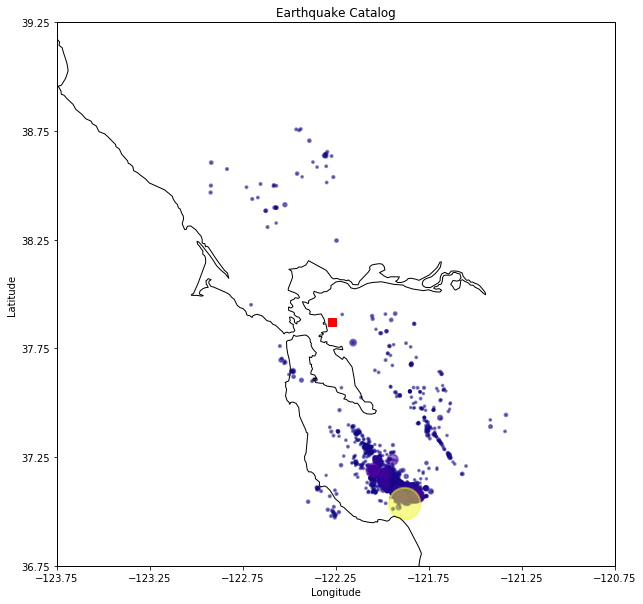

In [6]:
#Make a Map of the Earthquake Catalog

#Set Corners of Map
lat0=36.75
lat1=39.0
lon0=-123.75
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)


plt.figure(1,(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=1)
ax.set_aspect('auto')
ax.set_xticks(lonticks)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set(xlabel='Longitude', ylabel='Latitude',
       title='Earthquake Catalog')

x=lon
y=lat
z=mag

#Sort Descending to plot largest events on top
indx=np.argsort(z)   #determine sort index
x=x[indx]            #apply sort index
y=y[indx]
z=np.exp(z[indx])    #exponent to scale marker size

c = plt.cm.plasma(z/max(z)) # colormap scales with magnitude
plt.scatter(x, y, s=(z), facecolors=c, alpha=0.5, edgecolors=c, marker='o', linewidth=2) # plot circles on EQs
plt.plot(-122.2727,37.8716,'rs',markersize=8)  # plot red square on Berkeley

fig.savefig("hw_ex5_map_raw.png")

plt.show()

##  Determine the number of days from the first event

In [7]:
#Determine the number of days from the first event
days=np.zeros(nevt) # initialize the size of the array days

for i in range(0,nevt,1):
    d0 = datetime.date(year[0], month[0], day[0])
    d1 = datetime.date(year[i], month[i], day[i])
    delta = d1 - d0
    days[i]=delta.days # fill days in with the number of days since the first event

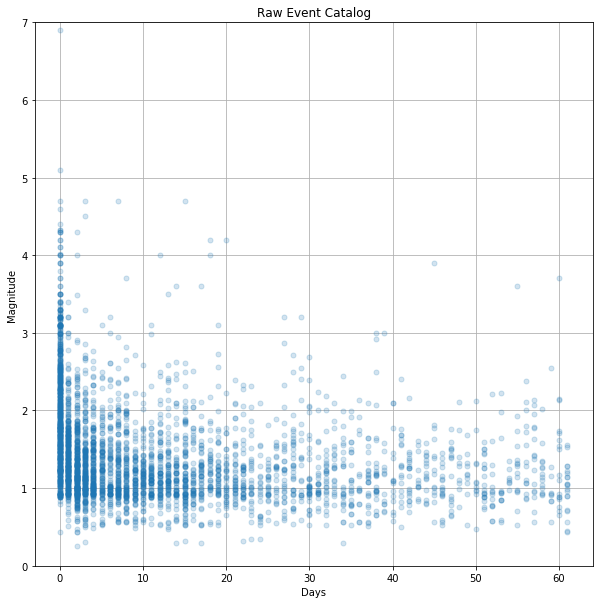

Number=3692 MinMag=0.25 MaxMag=6.90


In [8]:
# plot magnitude vs. time
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(days, mag,'o',alpha=0.2,markersize=5)
ax.set(xlabel='Days', ylabel='Magnitude',
       title='Raw Event Catalog')
ax.grid()
ax.set_ylim([0,7])
fig.savefig("hw_ex5_ts_raw.png")
plt.show()

print(f'Number={nevt:d} MinMag={min(mag):.2f} MaxMag={max(mag):.2f}')

## Define a function to compute the distance between two geographic points on a sphere

In [9]:
#This function computes the spherical earth distance between to geographic points and is used in the
#declustering algorithm below
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    
    The first pair can be singular and the second an array

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2]) # convert degrees lat, lon to radians

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2  # great circle inside sqrt

    c = 2 * np.arcsin(np.sqrt(a))   # great circle angular separation
    km = 6371.0 * c   # great circle distance in km, earth radius = 6371.0 km
    return km

## Decluster the Raw Catalog

We use the same decluster algorithm previously to identify aftershocks and remove them from the 30-day Loma Preita catalog.

In [10]:
#Decluster the Catalog  Note: This cell may take a few minute to complete

cnt=0 # initialize a counting variable
save=np.zeros((1,10000000),dtype=int) # initialize a counting variable

for i in range(0,nevt,1):   # step through EQ catalog
    
    # logical if statements to incorporate definitions of Dtest and Ttest aftershock window bounds
    Dtest=np.exp(1.77+(0.037+1.02*mag[i])**2)   # distance bounds
    if mag[i] >= 6.5:
        Ttest=abs(np.exp(-3.95+(0.62+17.32*mag[i])**2))  # aftershock time bounds for M >= 6.5
    else:
        Ttest=np.power(10,0.024*mag[i]+2.8)  # aftershock time bounds for M < 6.5
    
    a=days[i+1:nevt]-days[i]    # time interval in days to subsequent earthquakes in catalog
    m=mag[i+1:nevt]   # magnitudes of subsequent earthquakes in catalog
    b=haversine_np(lon[i],lat[i],lon[i+1:nevt],lat[i+1:nevt]) # distance in km to subsequent EQs in catalog
    
    icnt=np.count_nonzero(a <= Ttest)   # counts the number of potential aftershocks, 
                                        # the number of intervals <= Ttest bound
    if icnt > 0:  # if there are potential aftershocks
        itime=np.array(np.nonzero(a <= Ttest)) + (i+1) # indices of potential aftershocks <= Ttest bound
        for j in range(0,icnt,1):   # loops over the aftershocks         
            if b[j] <= Dtest and m[j] < mag[i]: # test if the event is inside the distance window 
                                                # and that the event is smaller than the current main EQ
                save[0][cnt]=itime[0][j]  # index value of the aftershock
                cnt += 1 # increment the counting variable

                
after=np.delete(np.unique(save),0)   # This is an array of indexes that will be used to delete events flagged 
                                      # as aftershocks    

Create two sets of arrays, one for the declustered catalog and one for the aftershock catalog. Use `np.delete()` to delete the aftershock events for the declustered catalog, and use `after` to select the aftershock events for the aftershock calalog. 

In [11]:
# delete the aftershock events
declustered_days=np.delete(days,after)  #The aftershocks are deleted from the days array 
declustered_mag=np.delete(mag,after)    #The aftershocks are deleted from the mag array 
declustered_lon=np.delete(lon,after)    #The aftershocks are deleted from the lon array 
declustered_lat=np.delete(lat,after)    #The aftershocks are deleted from the lat array 
n=len(declustered_days)
  

In [12]:
# select the aftershock events
aftershock_days=days[after]  #The aftershocks are selected from the days array 
aftershock_mag=mag[after]    #The aftershocks are selected from the mag array 
aftershock_lon=lon[after]    #The aftershocks are selected from the lon array 
aftershock_lat=lat[after]    #The aftershocks are selected from the lat array 
n2=len(aftershock_days)

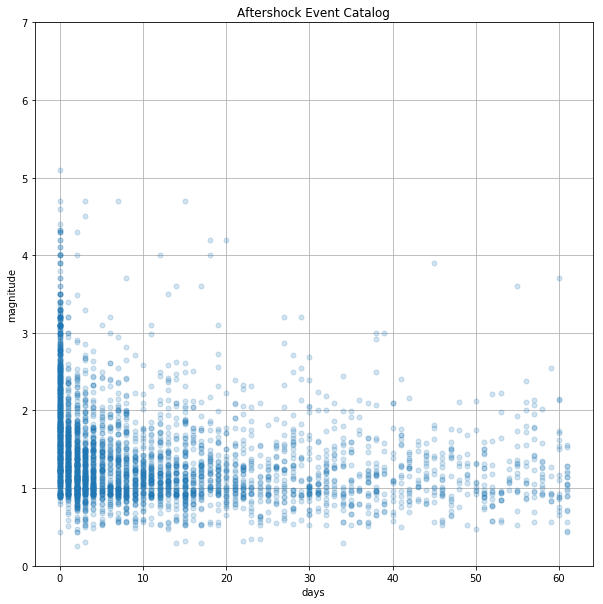

Number=3691 MinMag=0.25 MaxMag=5.10


In [13]:
#Plot Aftershock Catalog
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(aftershock_days, aftershock_mag,'o',alpha=0.2,markersize=5)
ax.set(xlabel='days', ylabel='magnitude',
       title='Aftershock Event Catalog')
ax.grid()
ax.set_ylim([0,7])
fig.savefig("hw_ex5_ts_aftershockOnly.png")
plt.show()

print(f'Number={n2:d} MinMag={min(aftershock_mag):.2f} MaxMag={max(aftershock_mag):.2f}')

### Questions
How many declustered events and aftershock events were there?

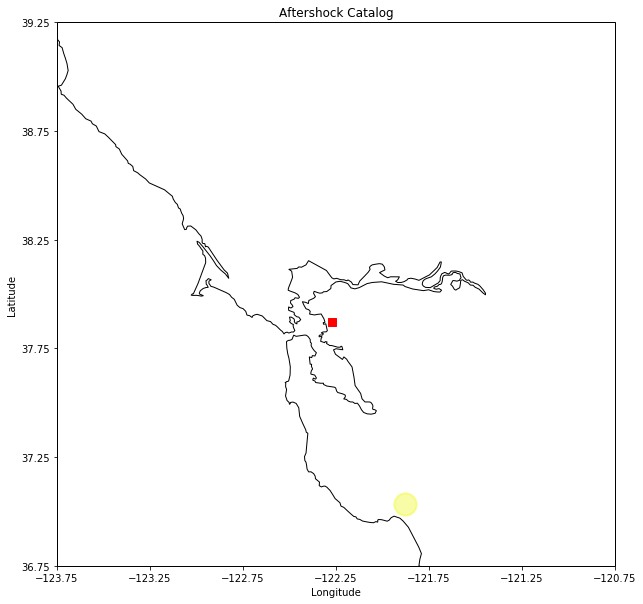

In [14]:
#Make a Map of the declustered events

#Set Corners of Map
lat0=36.75
lat1=39.0
lon0=-123.75
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)

plt.figure(1,(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(resolution='10m',linewidth=1) #downloaded 10m, 50m
ax.set_xticks(lonticks)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set(xlabel='Longitude', ylabel='Latitude',
       title='Aftershock Catalog')


x=declustered_lon
y=declustered_lat
z=declustered_mag

#Sort Descending to plot largest events on top
indx=np.argsort(z)   #determine sort index
x=x[indx]            #apply sort index
y=y[indx]
z=np.exp(z[indx])    #exponent to scale size

c = plt.cm.plasma(z/max(z))
plt.scatter(x, y, s=(z/2), facecolors=c, alpha=0.4, edgecolors=c, marker='o', linewidth=2)
plt.plot(-122.2727,37.8716,'rs',markersize=8)

fig.savefig("hw_ex5_map_mainshockOnly.png")


plt.show()

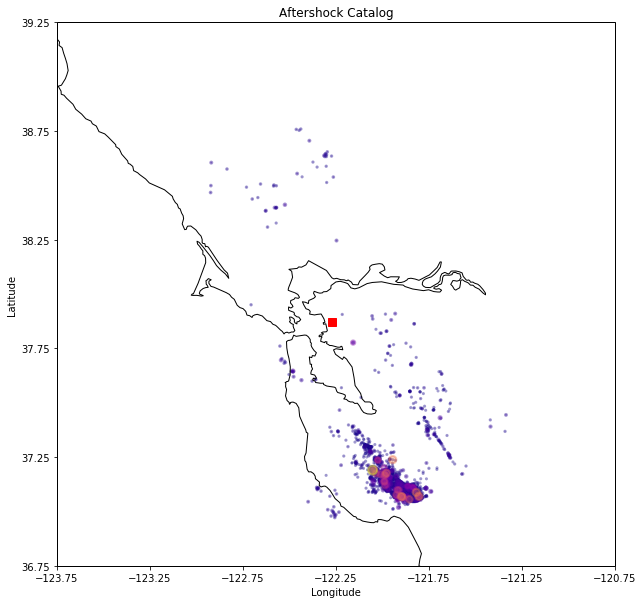

In [24]:
#Make a Map of Aftershock events

#Set Corners of Map
lat0=36.75
lat1=39.0
lon0=-123.75
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)

plt.figure(1,(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(resolution='10m',linewidth=1) #downloaded 10m, 50m
ax.set_xticks(lonticks)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set(xlabel='Longitude', ylabel='Latitude',
       title='Aftershock Catalog')


x=aftershock_lon
y=aftershock_lat
z=aftershock_mag

#Sort Descending to plot largest events on top
indx=np.argsort(z)   #determine sort index
x=x[indx]            #apply sort index
y=y[indx]
z=np.exp(z[indx])    #exponent to scale size

c = plt.cm.plasma(z/max(z))
plt.scatter(x, y, s=(z/2), facecolors=c, alpha=0.4, edgecolors=c, marker='o', linewidth=2)
plt.plot(-122.2727,37.8716,'rs',markersize=8)

fig.savefig("hw_ex5_map_aftershockOnly.png")

plt.show()

### Questions

1. What faults were active?

2. What could cause aftershocks to occur on faults other than the mainshock fault?

3. Here we used a 3-month period beginning at the Loma Prieta Earthquake. Examine the results taking a 6-month period beginning 3 months before the Loma Prieta earthquake. How does the distribution of earthquakes differ for the two time periods.

## Omori statistics

To compute the Omori statistics we want to bin the log10 of the number of aftershocks each day following the mainshock and fit a power law equation such as:

\begin{matrix}
N=\frac{A}{(t+\epsilon)^P}, 
\end{matrix}

where t is time in days, N is the number of earthquakes in the 24 hour period, and $\epsilon$ is a small number (fraction of a day) to avoid the singularity at zero time. A and P are the coeffients that we want to find through regression. This power law equation can be linearized by simply taking the log10 of both sides giving:

\begin{matrix}
log_{10}(N)=a - P*log_{10}(t+\epsilon)
\end{matrix}

Note: We will use both the Gutenberg-Richter and the Omori Law statistics computed in Homework 1 in Homework 2 where we will examine the probability of earthquake occurrence and aftershock occurrence following a given mainshock.



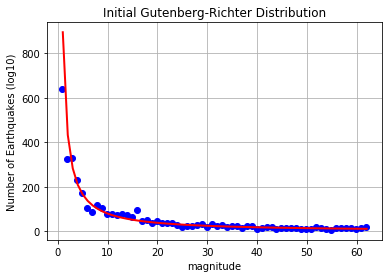

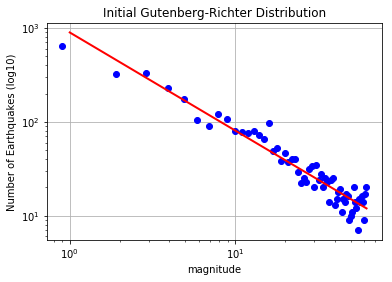

A_value= 2.952 P_value=-1.046


In [26]:
#find the number of aftershocks in each day
epsilon=0.1
maxdays=np.int(np.max(aftershock_days))
t=np.arange(1,maxdays+2,1)
logt=np.log10(t)
N=np.zeros(maxdays+1)

for i in range(0,maxdays+1,1):
    N[i]=np.count_nonzero(aftershock_days == i)
logN=np.log10(N)

#Invert for A and B values
tmp=np.ones(len(logN))
A=np.column_stack((tmp,logt))
ATA=np.dot(np.transpose(A),A)
ATD=np.dot(np.transpose(A),logN)
soln=np.linalg.solve(ATA,ATD)
x=t
y=10**np.dot(A,soln)

#Now Plot
fig, ax = plt.subplots()
ax.plot(t-epsilon, N,'bo',x,y,'r-',linewidth=2)
ax.set(xlabel='magnitude', ylabel='Number of Earthquakes (log10)',
       title='Initial Gutenberg-Richter Distribution')
ax.grid()
fig.savefig("hw_ex5_GNstats_linlin.png")
plt.show()

#Now Plot
fig, ax = plt.subplots()
ax.loglog(t-epsilon, N,'bo',x,y,'r-',linewidth=2)
ax.set(xlabel='magnitude', ylabel='Number of Earthquakes (log10)',
       title='Initial Gutenberg-Richter Distribution')
ax.grid()
fig.savefig("hw_ex5_GNstats_loglog.png")
plt.show()

print(f'A_value= {soln[0]:.3f} P_value={soln[1]:.3f}')

### Questions

1. How does the estimated P-value compare to values reported in Lay and Wallace?

2. Is the aftershock more or less productive than average?

3. What is the number of earthquakes per day in the region for the period leading up to the Loma Prieta earthquake?

4. How long after the earthquake would does the applied Omori Law predict the that the aftershock rate falls to the pre-event rate of earthquakes?


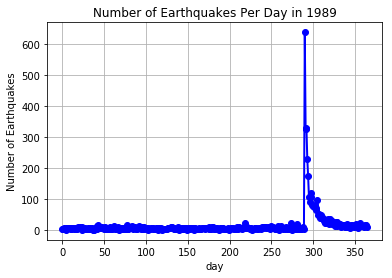

In [30]:
#plot of the number of earthquakes per day for 1989

#  create data arrays for the entirety of 1989
year=EQ_1989.Year.values
month=EQ_1989.Month.values
day=EQ_1989.Day.values
nevt=len(year)        #number of events 

#Determine the number of days from the first event
days=np.zeros(nevt) # initialize the size of the array days

for i in range(0,nevt,1):
    d0 = datetime.date(year[0], month[0], day[0])
    d1 = datetime.date(year[i], month[i], day[i])
    delta = d1 - d0
    days[i]=delta.days # fill days in with the number of days since the first event
    
maxdays=np.int(np.max(days))
NN=np.zeros(maxdays+1)
t=np.arange(0,maxdays+1,1)
for i in range(0,maxdays+1,1):
    NN[i]=np.count_nonzero(days == i)

#Now Plot
fig, ax = plt.subplots()
ax.plot(t, NN,'bo-',linewidth=2)
ax.set(xlabel='day', ylabel='Number of Earthquakes',
       title='Number of Earthquakes Per Day in 1989')
ax.grid()
fig.savefig("hw1_ex5_omori.png")
plt.show()